In [1]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import numpy as np
import random


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

to_pil = transforms.ToPILImage()
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    x = x.cpu()
    return to_pil(x)

def show_images(images : [] , title_msg : str = None , labels : np.array = None):
    def last_argmin(arr):
        arr_rev = arr[::-1]
        return len(arr_rev) - 1 - np.argmin(arr_rev)

    img_num = len(images)

    col_set = [2, 3, 5]
    x = [img_num % i for i in col_set]
    cols = col_set[last_argmin(x)]
    rows = math.ceil(img_num / cols)

    fig = plt.figure(figsize=(cols, rows))
    for i in range(img_num):
        ax = fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        if labels is not None:
            ax.set_xlabel(labels[i])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    if title_msg is not None:
        plt.suptitle(title_msg)
    plt.tight_layout()
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

In [2]:
# @title UNetCond

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim)

        if labels is not None:
            t += self.label_emb(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x


In [5]:
# @title Diffuser

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t, labels):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)  # add lable embedding
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)
        else:
            labels = labels.to(self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)

        images = [reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels

In [11]:
def train(dataset, batch_size, label_list,
          diffuser, num_timesteps,
          model, img_ch, img_size, device,
          epochs, lr):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        cnt = 0

        # generate samples every epoch ===================
        # images, labels = diffuser.sample(model)
        # show_images(images, labels)
        # ================================================

        for images, labels in tqdm(dataloader):
            optimizer.zero_grad()
            x = images.to(device)
            l = labels.to(device)
            t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t, l)
            loss = F.mse_loss(noise, noise_pred)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            cnt += 1

        if epoch % 10 == 0:
            labels = torch.tensor(np.random.choice(label_list, 9), device = device)
            test_images, labels = diffuser.sample(model, x_shape = (9, img_ch, img_size, img_size), labels = labels)
            l_lst = labels.cpu().numpy()
            show_images(test_images, title_msg = f"Epoch {epoch}", labels = l_lst)

        loss_avg = loss_sum / cnt
        losses.append(loss_avg)
        print(f'Epoch {epoch} | Loss: {loss_avg}')

    # plot losses
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # generate samples
    labels = torch.tensor(np.random.choice(label_list, 9), device = device)
    images ,labels = diffuser.sample(model, x_shape = (9, img_ch, img_size, img_size), labels = labels)
    l_lst = labels.cpu().numpy()
    show_images(images, title_msg = "Test Images", labels = l_lst)

#--------

# img_size = 28
# batch_size = 128
# num_timesteps = 1000
# epochs = 100
# lr = 1e-3
# # -----

# preprocess = transforms.Compose([
#     transforms.Resize(img_size),  # Resize the image
#     transforms.CenterCrop(img_size), # Crop the center
#     transforms.ToTensor() # Convert the image to a tensor
# ])

# fashion_dataset = torchvision.datasets.FashionMNIST(root='./temp_data', download=True, transform=preprocess)
# label_set = set()
# img_lst = []
# y_lst = []
# for i, d in enumerate(fashion_dataset):
#     label_set.add(d[1])
#     if i < 9:
#         img_lst.append(reverse_to_img(d[0]))
#         y_lst.append(d[1])
# show_images(img_lst, title_msg = "Ground Images", labels = y_lst)
# print(f"Size of dataset: {len(label_set)}")
# print(f"Label Set : {label_set}")

# label_list = list(label_set)
# num_labels = len(label_list)

# fashion_diffuser = Diffuser(num_timesteps, device=device)
# fashion_model = UNetCond(in_ch = 1, num_labels = num_labels)
# fashion_model.to(device)

# train(dataset = fashion_dataset, batch_size =  batch_size, label_list = label_list,
#       diffuser = fashion_diffuser, num_timesteps =  num_timesteps,
#       model = fashion_model, img_ch = 1, img_size =  img_size,
#       device = device, epochs =  epochs, lr = lr)

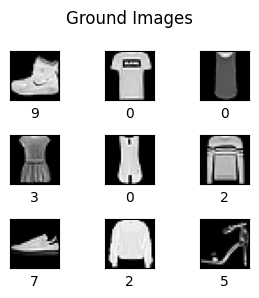

Size of dataset: 10
Label Set : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


100%|██████████| 1000/1000 [00:12<00:00, 80.78it/s]


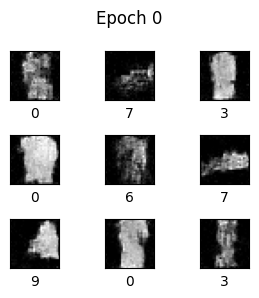

Epoch 0 | Loss: 0.06416058394986429


100%|██████████| 469/469 [00:46<00:00, 10.13it/s]


Epoch 1 | Loss: 0.03700350619344188


100%|██████████| 469/469 [00:44<00:00, 10.48it/s]


Epoch 2 | Loss: 0.033606001864999596


100%|██████████| 469/469 [00:49<00:00,  9.57it/s]


Epoch 3 | Loss: 0.031081767222568044


100%|██████████| 469/469 [00:48<00:00,  9.75it/s]


Epoch 4 | Loss: 0.029330943347707486


100%|██████████| 469/469 [00:40<00:00, 11.46it/s]


Epoch 5 | Loss: 0.028463802917965693


100%|██████████| 469/469 [00:42<00:00, 11.09it/s]


Epoch 6 | Loss: 0.027743027178145675


100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


Epoch 7 | Loss: 0.027095935541763108


100%|██████████| 469/469 [00:38<00:00, 12.24it/s]


Epoch 8 | Loss: 0.026405541121022405


100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Epoch 9 | Loss: 0.026175122960274026


100%|██████████| 1000/1000 [00:11<00:00, 89.30it/s]


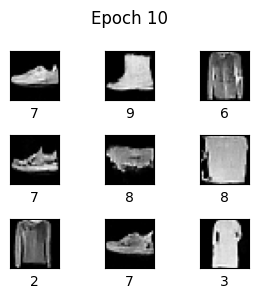

Epoch 10 | Loss: 0.025785731753386033


100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Epoch 11 | Loss: 0.024853555789427845


100%|██████████| 469/469 [00:38<00:00, 12.15it/s]


Epoch 12 | Loss: 0.024553596937675466


100%|██████████| 469/469 [00:38<00:00, 12.29it/s]


Epoch 13 | Loss: 0.02494369235747595


100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Epoch 14 | Loss: 0.024660802223900363


100%|██████████| 469/469 [00:38<00:00, 12.30it/s]


Epoch 15 | Loss: 0.0243199481479903


100%|██████████| 469/469 [00:38<00:00, 12.29it/s]


Epoch 16 | Loss: 0.024152418644205212


100%|██████████| 469/469 [00:38<00:00, 12.30it/s]


Epoch 17 | Loss: 0.023696202524641812


100%|██████████| 469/469 [00:39<00:00, 11.91it/s]


Epoch 18 | Loss: 0.023742483730223387


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch 19 | Loss: 0.02370888895110916


100%|██████████| 1000/1000 [00:11<00:00, 86.83it/s]


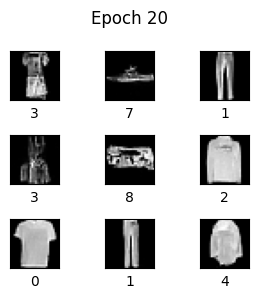

Epoch 20 | Loss: 0.023685648481347667


100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


Epoch 21 | Loss: 0.02338646474614072


100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Epoch 22 | Loss: 0.02338115856059388


100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


Epoch 23 | Loss: 0.023503299723111236


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch 24 | Loss: 0.02287995766427344


100%|██████████| 469/469 [00:40<00:00, 11.71it/s]


Epoch 25 | Loss: 0.022680255246839164


100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


Epoch 26 | Loss: 0.02295986593746618


100%|██████████| 469/469 [00:44<00:00, 10.51it/s]


Epoch 27 | Loss: 0.02283188974512602


100%|██████████| 469/469 [00:39<00:00, 11.75it/s]


Epoch 28 | Loss: 0.02277702611408381


100%|██████████| 469/469 [00:54<00:00,  8.67it/s]


Epoch 29 | Loss: 0.023090639816863195


100%|██████████| 1000/1000 [00:11<00:00, 84.45it/s]


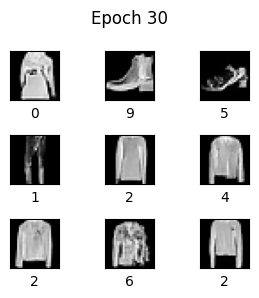

Epoch 30 | Loss: 0.022564656758454562


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch 31 | Loss: 0.022885955411440402


100%|██████████| 469/469 [00:57<00:00,  8.11it/s]


Epoch 32 | Loss: 0.022603514000598682


100%|██████████| 469/469 [01:00<00:00,  7.70it/s]


Epoch 33 | Loss: 0.02246829860015655


100%|██████████| 469/469 [01:03<00:00,  7.41it/s]


Epoch 34 | Loss: 0.022666255000240006


100%|██████████| 469/469 [01:02<00:00,  7.51it/s]


Epoch 35 | Loss: 0.022214936451918917


100%|██████████| 469/469 [01:01<00:00,  7.69it/s]


Epoch 36 | Loss: 0.02226403972376257


100%|██████████| 469/469 [00:59<00:00,  7.83it/s]


Epoch 37 | Loss: 0.02237991757913312


100%|██████████| 469/469 [00:58<00:00,  7.97it/s]


Epoch 38 | Loss: 0.02201235489741063


100%|██████████| 469/469 [00:58<00:00,  8.03it/s]


Epoch 39 | Loss: 0.022299835122804017


100%|██████████| 1000/1000 [00:11<00:00, 84.50it/s]


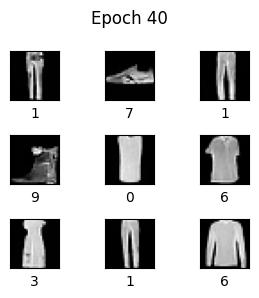

Epoch 40 | Loss: 0.022055353723101016


100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


Epoch 41 | Loss: 0.022425994709896636


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 42 | Loss: 0.02227166845107765


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 43 | Loss: 0.022291018196673534


100%|██████████| 469/469 [00:56<00:00,  8.23it/s]


Epoch 44 | Loss: 0.02201863359818771


100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 45 | Loss: 0.022063922411057233


100%|██████████| 469/469 [00:57<00:00,  8.15it/s]


Epoch 46 | Loss: 0.021935576128203477


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 47 | Loss: 0.02172828469274522


100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


Epoch 48 | Loss: 0.021945496121528688


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch 49 | Loss: 0.022197269103817467


100%|██████████| 1000/1000 [00:11<00:00, 88.18it/s]


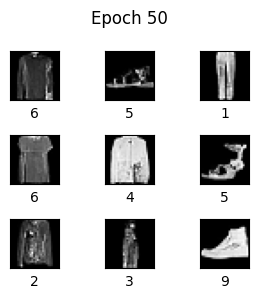

Epoch 50 | Loss: 0.02202943303207281


100%|██████████| 469/469 [00:57<00:00,  8.19it/s]


Epoch 51 | Loss: 0.02176674307862134


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 52 | Loss: 0.02177403610684216


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch 53 | Loss: 0.02160638712370383


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch 54 | Loss: 0.021162432691912408


100%|██████████| 469/469 [00:57<00:00,  8.17it/s]


Epoch 55 | Loss: 0.02152362916229376


100%|██████████| 469/469 [00:57<00:00,  8.18it/s]


Epoch 56 | Loss: 0.02154866001332429


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 57 | Loss: 0.021632169776443225


100%|██████████| 469/469 [00:56<00:00,  8.23it/s]


Epoch 58 | Loss: 0.021299955832249702


100%|██████████| 469/469 [00:56<00:00,  8.23it/s]


Epoch 59 | Loss: 0.021343607540879803


100%|██████████| 1000/1000 [00:11<00:00, 85.81it/s]


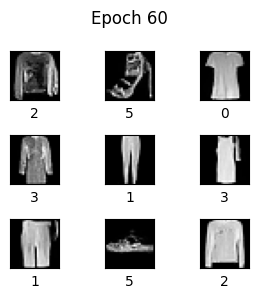

Epoch 60 | Loss: 0.0217746020670035


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 61 | Loss: 0.02132897335750017


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch 62 | Loss: 0.02158957593706943


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch 63 | Loss: 0.02151549898826682


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch 64 | Loss: 0.021559956201564656


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch 65 | Loss: 0.021391099096456572


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch 66 | Loss: 0.021454697959363334


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 67 | Loss: 0.021775093124206387


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch 68 | Loss: 0.02140143313911805


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch 69 | Loss: 0.02113527104234708


100%|██████████| 1000/1000 [00:11<00:00, 86.85it/s]


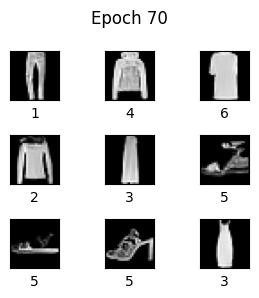

Epoch 70 | Loss: 0.021083119057261866


100%|██████████| 469/469 [00:55<00:00,  8.46it/s]


Epoch 71 | Loss: 0.021975219910984226


100%|██████████| 469/469 [00:56<00:00,  8.25it/s]


Epoch 72 | Loss: 0.021286072253164198


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch 73 | Loss: 0.02152935779099462


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch 74 | Loss: 0.021164824628134144


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch 75 | Loss: 0.021456406404103425


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 76 | Loss: 0.021145292156651965


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 77 | Loss: 0.021261280601117403


100%|██████████| 469/469 [00:56<00:00,  8.24it/s]


Epoch 78 | Loss: 0.022796234374107327


100%|██████████| 469/469 [00:57<00:00,  8.17it/s]


Epoch 79 | Loss: 0.021384518313557227


100%|██████████| 1000/1000 [00:11<00:00, 86.33it/s]


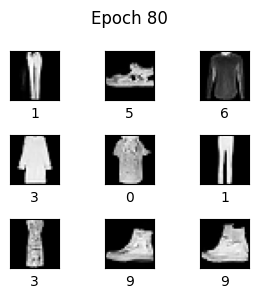

Epoch 80 | Loss: 0.021263911913055728


100%|██████████| 469/469 [00:52<00:00,  8.91it/s]


Epoch 81 | Loss: 0.021011190701411095


100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 82 | Loss: 0.021247008422226793


100%|██████████| 469/469 [00:56<00:00,  8.25it/s]


Epoch 83 | Loss: 0.021121376017326995


100%|██████████| 469/469 [00:58<00:00,  8.04it/s]


Epoch 84 | Loss: 0.021353705919214656


100%|██████████| 469/469 [00:57<00:00,  8.11it/s]


Epoch 85 | Loss: 0.020697169905421194


100%|██████████| 469/469 [00:59<00:00,  7.95it/s]


Epoch 86 | Loss: 0.021012518687972


100%|██████████| 469/469 [00:58<00:00,  7.96it/s]


Epoch 87 | Loss: 0.02117943376310662


100%|██████████| 469/469 [00:57<00:00,  8.13it/s]


Epoch 88 | Loss: 0.021143994447010667


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch 89 | Loss: 0.02103177771004024


100%|██████████| 1000/1000 [00:11<00:00, 89.96it/s]


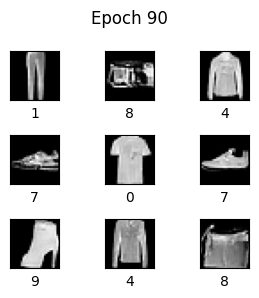

Epoch 90 | Loss: 0.021380172996744037


100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Epoch 91 | Loss: 0.021264907254624977


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch 92 | Loss: 0.021146235276641112


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 93 | Loss: 0.021061624249399724


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 94 | Loss: 0.02140821453168003


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch 95 | Loss: 0.021226206867854352


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch 96 | Loss: 0.021068154176923513


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 97 | Loss: 0.021030568386684222


100%|██████████| 469/469 [00:57<00:00,  8.16it/s]


Epoch 98 | Loss: 0.02108325761582043


100%|██████████| 469/469 [00:57<00:00,  8.11it/s]

Epoch 99 | Loss: 0.02124619636652884


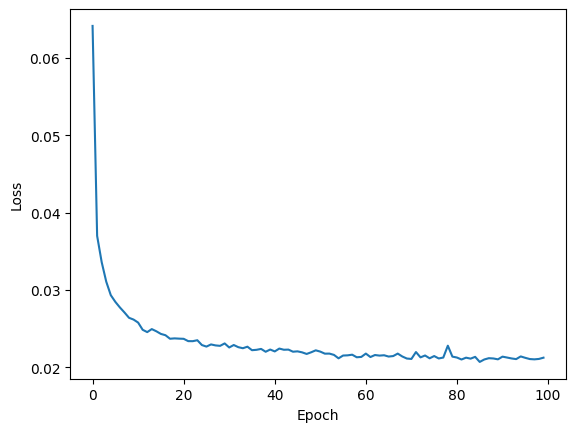

100%|██████████| 1000/1000 [00:11<00:00, 87.26it/s]


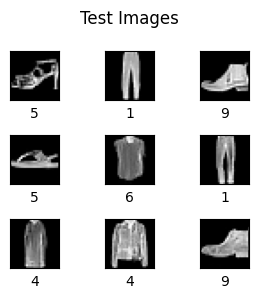

In [12]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 100
lr = 1e-3
# -----

preprocess = transforms.Compose([
    transforms.Resize(img_size),  # Resize the image
    transforms.CenterCrop(img_size), # Crop the center
    transforms.ToTensor() # Convert the image to a tensor
])

fashion_dataset = torchvision.datasets.FashionMNIST(root='./temp_data', download=True, transform=preprocess)
label_set = set()
img_lst = []
y_lst = []
for i, d in enumerate(fashion_dataset):
    label_set.add(d[1])
    if i < 9:
        img_lst.append(reverse_to_img(d[0]))
        y_lst.append(d[1])
show_images(img_lst, title_msg = "Ground Images", labels = y_lst)
print(f"Size of dataset: {len(label_set)}")
print(f"Label Set : {label_set}")

label_list = list(label_set)
num_labels = len(label_list)

fashion_diffuser = Diffuser(num_timesteps, device=device)
fashion_model = UNetCond(in_ch = 1, num_labels = num_labels)
fashion_model.to(device)

train(dataset = fashion_dataset, batch_size =  batch_size, label_list = label_list,
      diffuser = fashion_diffuser, num_timesteps =  num_timesteps,
      model = fashion_model, img_ch = 1, img_size =  img_size,
      device = device, epochs =  epochs, lr = lr)

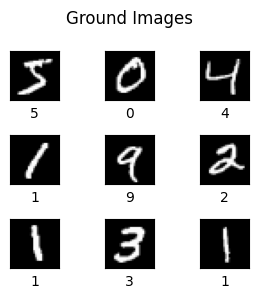

Size of dataset: 10
Label Set : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


100%|██████████| 1000/1000 [00:11<00:00, 90.67it/s]


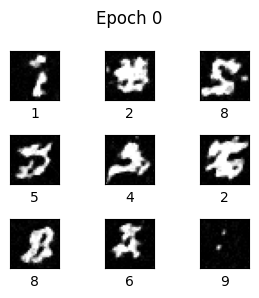

Epoch 0 | Loss: 0.05044468118151876


100%|██████████| 469/469 [00:55<00:00,  8.41it/s]


Epoch 1 | Loss: 0.027826351290350274


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch 2 | Loss: 0.02328872303369203


100%|██████████| 469/469 [00:58<00:00,  8.03it/s]


Epoch 3 | Loss: 0.02170927732833413


100%|██████████| 469/469 [01:00<00:00,  7.71it/s]


Epoch 4 | Loss: 0.020191259483602255


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Epoch 5 | Loss: 0.019298144167404312


100%|██████████| 469/469 [01:01<00:00,  7.57it/s]


Epoch 6 | Loss: 0.01891123024877836


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Epoch 7 | Loss: 0.01789151484182458


100%|██████████| 469/469 [01:01<00:00,  7.57it/s]


Epoch 8 | Loss: 0.017946087685761166


100%|██████████| 469/469 [00:52<00:00,  8.89it/s]


Epoch 9 | Loss: 0.017301084549188106


100%|██████████| 1000/1000 [00:11<00:00, 86.27it/s]


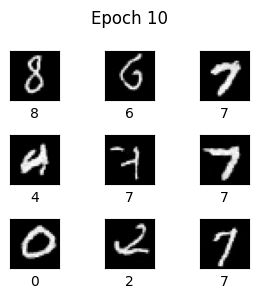

Epoch 10 | Loss: 0.01717281190237638


100%|██████████| 469/469 [01:01<00:00,  7.60it/s]


Epoch 11 | Loss: 0.017219331212786595


100%|██████████| 469/469 [01:01<00:00,  7.59it/s]


Epoch 12 | Loss: 0.01687509320708099


100%|██████████| 469/469 [01:01<00:00,  7.58it/s]


Epoch 13 | Loss: 0.016404119679636793


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Epoch 14 | Loss: 0.016567122079988023


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Epoch 15 | Loss: 0.016320018820575814


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Epoch 16 | Loss: 0.016282186642892833


100%|██████████| 469/469 [01:01<00:00,  7.58it/s]


Epoch 17 | Loss: 0.01591822846945542


100%|██████████| 469/469 [01:01<00:00,  7.60it/s]


Epoch 18 | Loss: 0.015640394878325494


100%|██████████| 469/469 [00:54<00:00,  8.59it/s]


Epoch 19 | Loss: 0.01564059425185103


100%|██████████| 1000/1000 [00:11<00:00, 85.89it/s]


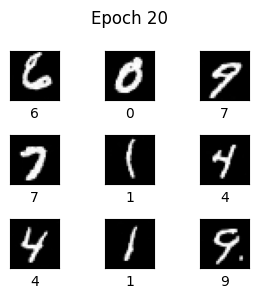

Epoch 20 | Loss: 0.015649726767259748


100%|██████████| 469/469 [01:01<00:00,  7.58it/s]


Epoch 21 | Loss: 0.015603720494456637


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Epoch 22 | Loss: 0.015711488706597894


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Epoch 23 | Loss: 0.015271207409054995


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Epoch 24 | Loss: 0.015389580637025935


100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


Epoch 25 | Loss: 0.01520120716496889


100%|██████████| 469/469 [01:02<00:00,  7.50it/s]


Epoch 26 | Loss: 0.01541227465078457


100%|██████████| 469/469 [01:02<00:00,  7.52it/s]


Epoch 27 | Loss: 0.015184241537648096


100%|██████████| 469/469 [00:58<00:00,  8.02it/s]


Epoch 28 | Loss: 0.014916949343484347


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 29 | Loss: 0.015098542036579997


100%|██████████| 1000/1000 [00:10<00:00, 93.30it/s]


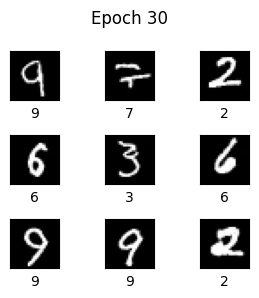

Epoch 30 | Loss: 0.014899016234841047


100%|██████████| 469/469 [00:37<00:00, 12.54it/s]


Epoch 31 | Loss: 0.014960570324426775


100%|██████████| 469/469 [00:37<00:00, 12.50it/s]


Epoch 32 | Loss: 0.015027049416576876


100%|██████████| 469/469 [00:37<00:00, 12.53it/s]


Epoch 33 | Loss: 0.014719560232037293


100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Epoch 34 | Loss: 0.014760868633781541


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 35 | Loss: 0.01477878692466567


100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Epoch 36 | Loss: 0.015284986844830421


100%|██████████| 469/469 [00:37<00:00, 12.55it/s]


Epoch 37 | Loss: 0.014599894973705573


100%|██████████| 469/469 [00:37<00:00, 12.58it/s]


Epoch 38 | Loss: 0.014710560728952701


100%|██████████| 469/469 [00:37<00:00, 12.60it/s]


Epoch 39 | Loss: 0.014532662131813671


100%|██████████| 1000/1000 [00:10<00:00, 93.41it/s]


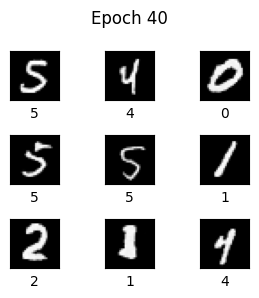

Epoch 40 | Loss: 0.014652017361001928


100%|██████████| 469/469 [00:37<00:00, 12.57it/s]


Epoch 41 | Loss: 0.01449717999672267


100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Epoch 42 | Loss: 0.014528635214132541


100%|██████████| 469/469 [00:37<00:00, 12.62it/s]


Epoch 43 | Loss: 0.01464749295820496


100%|██████████| 469/469 [00:37<00:00, 12.58it/s]


Epoch 44 | Loss: 0.014481706820777866


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 45 | Loss: 0.014488733905766691


100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Epoch 46 | Loss: 0.014419600709097218


100%|██████████| 469/469 [00:37<00:00, 12.44it/s]


Epoch 47 | Loss: 0.01452928814075903


100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Epoch 48 | Loss: 0.014381731228867193


100%|██████████| 469/469 [00:37<00:00, 12.58it/s]


Epoch 49 | Loss: 0.014325210533694609


100%|██████████| 1000/1000 [00:09<00:00, 100.10it/s]


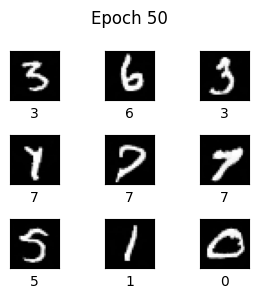

Epoch 50 | Loss: 0.014478399273333773


100%|██████████| 469/469 [00:47<00:00,  9.81it/s]


Epoch 51 | Loss: 0.014224837722777049


100%|██████████| 469/469 [00:46<00:00, 10.08it/s]


Epoch 52 | Loss: 0.01425719428966358


100%|██████████| 469/469 [00:46<00:00, 10.00it/s]


Epoch 53 | Loss: 0.014183354851946647


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 54 | Loss: 0.014215437584181331


100%|██████████| 469/469 [00:47<00:00,  9.87it/s]


Epoch 55 | Loss: 0.014266612538412562


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 56 | Loss: 0.014248936540330015


100%|██████████| 469/469 [00:47<00:00,  9.89it/s]


Epoch 57 | Loss: 0.014236311340875336


100%|██████████| 469/469 [00:47<00:00,  9.91it/s]


Epoch 58 | Loss: 0.014283215891180643


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 59 | Loss: 0.014228400383104902


100%|██████████| 1000/1000 [00:10<00:00, 92.00it/s]


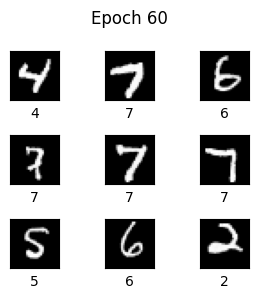

Epoch 60 | Loss: 0.014011912244453487


100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Epoch 61 | Loss: 0.014132800259823993


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 62 | Loss: 0.014141344487158728


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 63 | Loss: 0.014128476043722268


100%|██████████| 469/469 [00:48<00:00,  9.72it/s]


Epoch 64 | Loss: 0.014331571412270766


100%|██████████| 469/469 [00:47<00:00,  9.92it/s]


Epoch 65 | Loss: 0.01422314713996992


100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


Epoch 66 | Loss: 0.014354175087739663


100%|██████████| 469/469 [00:47<00:00,  9.80it/s]


Epoch 67 | Loss: 0.01409780233701282


100%|██████████| 469/469 [00:43<00:00, 10.66it/s]


Epoch 68 | Loss: 0.014114076599303974


100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Epoch 69 | Loss: 0.014100708661160108


100%|██████████| 1000/1000 [00:10<00:00, 93.43it/s]


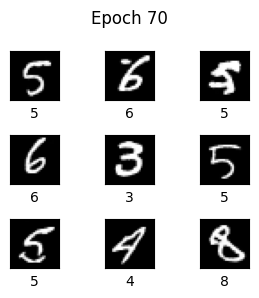

Epoch 70 | Loss: 0.014172291839872597


100%|██████████| 469/469 [00:37<00:00, 12.46it/s]


Epoch 71 | Loss: 0.014249806171223553


100%|██████████| 469/469 [00:40<00:00, 11.58it/s]


Epoch 72 | Loss: 0.014046328630782902


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 73 | Loss: 0.014025020905569799


100%|██████████| 469/469 [00:47<00:00,  9.84it/s]


Epoch 74 | Loss: 0.014032429362188525


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 75 | Loss: 0.013875918878889733


100%|██████████| 469/469 [00:47<00:00,  9.92it/s]


Epoch 76 | Loss: 0.014088486684664989


100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


Epoch 77 | Loss: 0.013895479829183646


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 78 | Loss: 0.013902536521890142


100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 79 | Loss: 0.013947992653115344


100%|██████████| 1000/1000 [00:10<00:00, 98.42it/s]


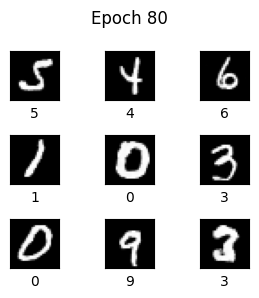

Epoch 80 | Loss: 0.0138945403709404


100%|██████████| 469/469 [00:48<00:00,  9.69it/s]


Epoch 81 | Loss: 0.013902482725600443


100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


Epoch 82 | Loss: 0.014036195271257271


100%|██████████| 469/469 [00:46<00:00, 10.00it/s]


Epoch 83 | Loss: 0.013971183091592686


100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 84 | Loss: 0.013916279403750958


100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 85 | Loss: 0.013997174952345998


100%|██████████| 469/469 [00:47<00:00,  9.93it/s]


Epoch 86 | Loss: 0.014118234928784721


100%|██████████| 469/469 [00:46<00:00, 10.00it/s]


Epoch 87 | Loss: 0.013868774942704228


100%|██████████| 469/469 [00:47<00:00,  9.98it/s]


Epoch 88 | Loss: 0.013816310857325348


100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


Epoch 89 | Loss: 0.013962459468495236


100%|██████████| 1000/1000 [00:10<00:00, 99.36it/s]


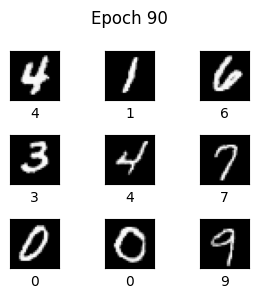

Epoch 90 | Loss: 0.013987157453121598


100%|██████████| 469/469 [00:42<00:00, 11.12it/s]


Epoch 91 | Loss: 0.013724684548466953


100%|██████████| 469/469 [00:54<00:00,  8.66it/s]


Epoch 92 | Loss: 0.013813872829572096


100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Epoch 93 | Loss: 0.01358034703801118


100%|██████████| 469/469 [01:00<00:00,  7.79it/s]


Epoch 94 | Loss: 0.013751160344486235


100%|██████████| 469/469 [01:03<00:00,  7.35it/s]


Epoch 95 | Loss: 0.013670628419769472


100%|██████████| 469/469 [01:04<00:00,  7.32it/s]


Epoch 96 | Loss: 0.013851333485006778


100%|██████████| 469/469 [01:03<00:00,  7.38it/s]


Epoch 97 | Loss: 0.013766269614574497


100%|██████████| 469/469 [01:01<00:00,  7.58it/s]


Epoch 98 | Loss: 0.013838918152839136


100%|██████████| 469/469 [01:00<00:00,  7.71it/s]

Epoch 99 | Loss: 0.013565374673334267


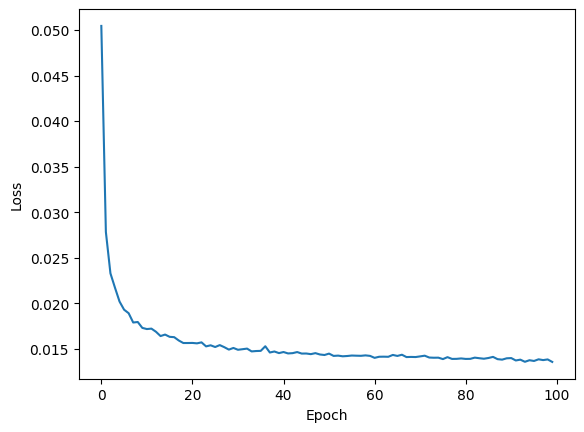

100%|██████████| 1000/1000 [00:11<00:00, 89.74it/s]


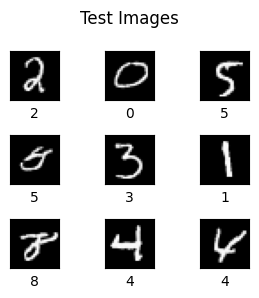

In [13]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 100
lr = 1e-3
# -----

preprocess = transforms.Compose([
    transforms.Resize(img_size),  # Resize the image
    transforms.CenterCrop(img_size), # Crop the center
    transforms.ToTensor() # Convert the image to a tensor
])

mnist_dataset = torchvision.datasets.MNIST(root='./temp_data', download=True, transform=preprocess)

label_set = set()
img_lst = []
y_lst = []
for i, d in enumerate(mnist_dataset):
    label_set.add(d[1])
    if i < 9:
        img_lst.append(reverse_to_img(d[0]))
        y_lst.append(d[1])
show_images(img_lst, title_msg = "Ground Images", labels = y_lst)
print(f"Size of dataset: {len(label_set)}")
print(f"Label Set : {label_set}")

label_list = list(label_set)
num_labels = len(label_list)

mnist_diffuser = Diffuser(num_timesteps, device=device)
mnist_model = UNetCond(in_ch = 1, num_labels = num_labels)
mnist_model.to(device)

train(dataset = mnist_dataset, batch_size =  batch_size, label_list = label_list,
      diffuser = mnist_diffuser, num_timesteps =  num_timesteps,
      model = mnist_model, img_ch = 1, img_size =  img_size,
      device = device, epochs = epochs, lr = lr)
